In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import time

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import CarliniLInfMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import MomentumIterativeMethod

e:\LICENCJAT\code\ART\venvART\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\LICENCJAT\code\ART\venvART\Lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
loaded_mnist = tf.keras.models.load_model("mnist-model.keras")

num_classes = 10

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_test = x_test.astype("float32") / 255
x_test = np.expand_dims(x_test, -1)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [3]:
def format_time(seconds):
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}:{seconds:02}"

def apply_attack(attack, attack_name, model, epsilon=None, norm=None, eps_step=None, iter=None):

    # Measure execution time
    start_time = time.time()

    # Apply the attack
    if eps_step is None and iter is None:
        adv_attack = attack(estimator=model, eps=epsilon, norm=norm)
    elif attack_name == "CW":
        adv_attack = attack(classifier=model, max_iter=iter, verbose=0)
    elif norm is None:
        adv_attack = attack(estimator=model, eps=epsilon, eps_step=eps_step, max_iter=iter)
    else:
        adv_attack = attack(estimator=model, eps=epsilon, norm=norm, eps_step=eps_step, max_iter=iter)
        
    adv_imgs = adv_attack.generate(x=x_test)

    end_time = time.time()
    execution_time = end_time - start_time
    formatted_time = format_time(execution_time)

    # Calculate robust accuracy
    score = loaded_mnist.evaluate(adv_imgs, y_test, verbose=0)

    # Prepare results with attack_name prefix
    x_adversarial_dict = {f'{attack_name}_adv': adv_imgs}
    attack_info = {
        f'{attack_name}_acc': round(score[1] * 100, 2),
        f'{attack_name}_time': formatted_time,
        
    }

    return x_adversarial_dict, attack_info

In [4]:
from typing import Dict, List, Any

def visualize_adversarial_attacks(
    library_name: str,
    x_test: np.ndarray,
    x_adversarial_dict: Dict[str, np.ndarray],
    attack_info: Dict[str, Any],
    indices: List[int]
):
    num_samples = len(indices)

    # Select samples to visualize using provided indices
    originals = x_test[indices]

    # Number of attacks to visualize
    attack_names = [key.replace('_adv', '') for key in x_adversarial_dict.keys()]
    num_attacks = len(attack_names)

    # Calculate the number of rows needed for two columns
    num_rows = (num_attacks + 1) // 2

    fig = plt.figure(layout="constrained", figsize=(15,15))
    fig.suptitle(f'Wizualizacja ataków zwodniczych ({library_name})', fontsize=17)
    subfigs = fig.subfigures(num_rows, 2, wspace=0.07)
    subfigs = subfigs.flatten()

    for i in range(len(subfigs)):
        
        adversarials = x_adversarial_dict[f'{attack_names[i]}_adv']
        accuracy = attack_info[f'{attack_names[i]}_acc']
        compile_time = attack_info[f'{attack_names[i]}_time']   
        subfigs[i].suptitle(f'{attack_names[i]}\nDokładność modelu po ataku: {accuracy}%\n Czas kompilacji: {compile_time} (mm:ss)', fontsize=16)

        axs = subfigs[i].subplots(3, 3)
        axs[0, 0].set_title('Oryginał', fontsize=16)
        axs[0, 1].set_title('Po ataku', fontsize=16)
        axs[0, 2].set_title('Zakłócenia', fontsize=16)
    
        row_offset = 0
        col_offset = 0
        
        for j in range(num_samples):
            og = originals[j]
            adv = adversarials[indices[j]]
            diff = (og - adv).reshape(28, 28)

            # Original image
            axs[row_offset, col_offset].imshow(og.reshape(28, 28), cmap='gray')
            axs[row_offset, col_offset].axis("off")
            # Adversarial image
            axs[row_offset, col_offset + 1].imshow(adv.reshape(28, 28), cmap='gray')
            axs[row_offset, col_offset+1].axis("off")    
            # Difference image
            axs[row_offset, col_offset + 2].imshow(diff, cmap='gray')
            axs[row_offset, col_offset+2].axis("off")
            
            row_offset += 1
        
        
        row_offset = 0
        col_offset = 0 

In [5]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=loaded_mnist, nb_classes=num_classes, input_shape=(28,28,1), loss_object=loss, )

In [6]:
eps = 0.1
eps_step=0.03
iter=40
norm = np.inf

indices = [7, 396, 925]

In [9]:
fgsm_adv, fgsm_info = apply_attack(FastGradientMethod, "FGSM", classifier, epsilon=eps, norm=norm)
bim_adv, bim_info = apply_attack(BasicIterativeMethod, "BIM", classifier, epsilon=eps, eps_step=eps_step, iter=iter)
pgd_adv, pgd_info = apply_attack(ProjectedGradientDescent, "PGD", classifier, epsilon=eps, eps_step=eps_step, iter=iter, norm=norm)
mim_adv, mim_info = apply_attack(MomentumIterativeMethod, "MIM", classifier, epsilon=eps, eps_step=eps_step, iter=iter, norm=norm)

In [25]:
cw_adv, cw_info = apply_attack(CarliniLInfMethod, "CW", classifier, iter=iter)

In [10]:
# Combine all adversarial data and attack info into single dictionaries
x_adversarial_dict = {**fgsm_adv, **bim_adv,  **mim_adv, **pgd_adv}
attack_info = {**fgsm_info, **bim_info, **mim_info, **pgd_info}

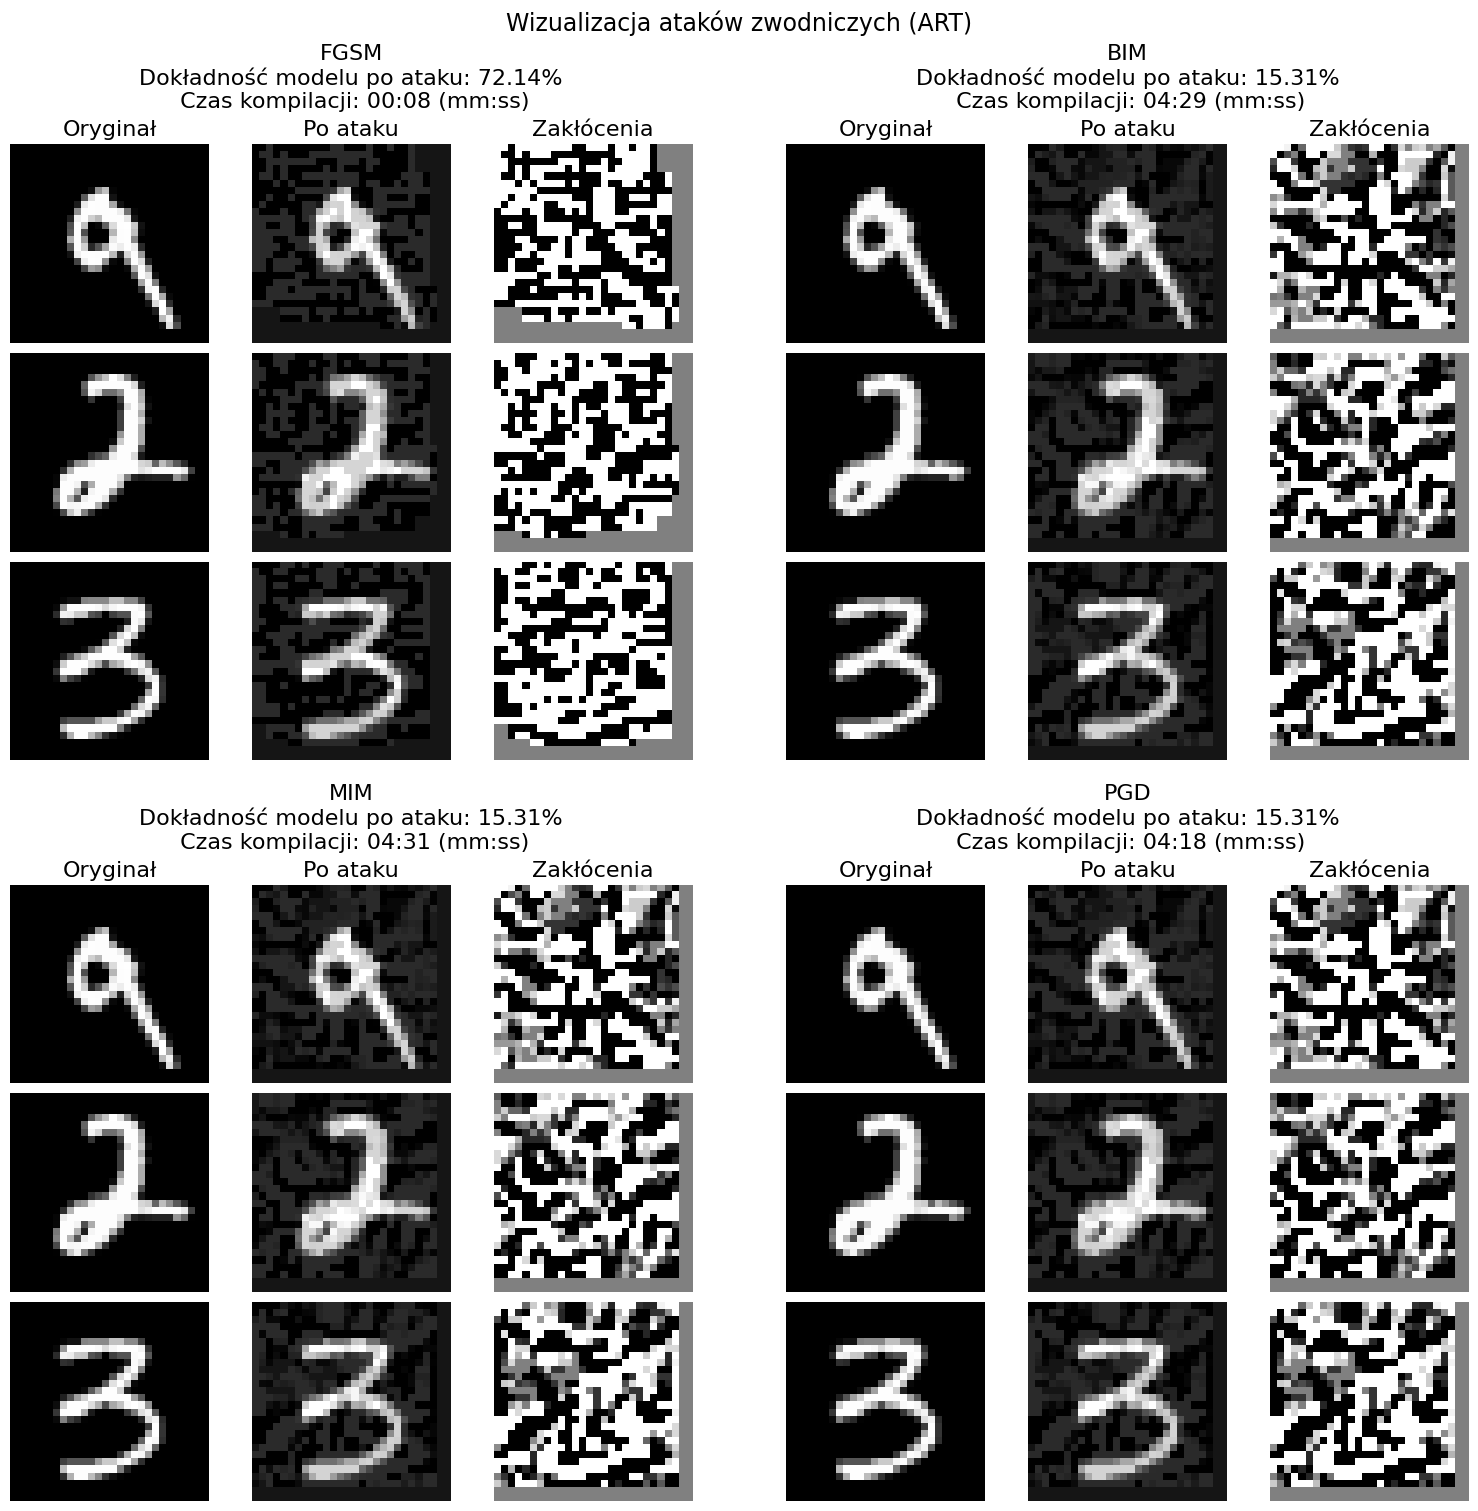

In [11]:
visualize_adversarial_attacks(library_name="ART", x_test=x_test, x_adversarial_dict=x_adversarial_dict, attack_info=attack_info, indices=indices)

In [32]:
# Define the plot_confusion_matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Helper function to plot confusion matrix for each attack
def plot_attack_confusion_matrix(y_true, y_pred, attack_name, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=range(num_classes), title=f'Confusion Matrix - {attack_name}')

# Function to generate predictions from adversarial images
def generate_predictions(adv_images, model):
    return np.argmax(model.predict(adv_images), axis=1)

# Extract and plot confusion matrices for different attacks
def attack_plot_matrix(adv_images, model, y_true, attack_name, num_classes):
    preds = generate_predictions(adv_images, model)
    plot_attack_confusion_matrix(y_true, preds, attack_name, num_classes)


# Convert y_test from one-hot encoding to class labels
y_test_labels = np.argmax(y_test, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


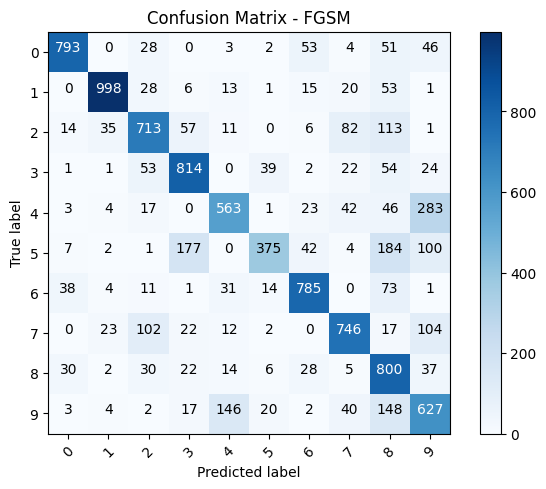

In [35]:
attack_plot_matrix(fgsm_adv['FGSM_adv'], loaded_mnist, y_test_labels, 'FGSM', num_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


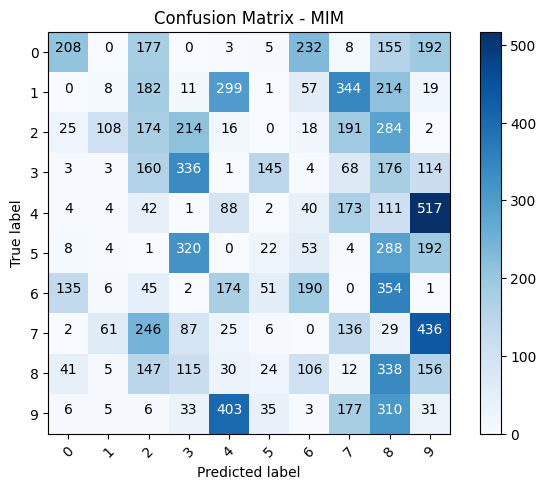

In [36]:
attack_plot_matrix(mim_adv['MIM_adv'], loaded_mnist, y_test_labels, 'MIM', num_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


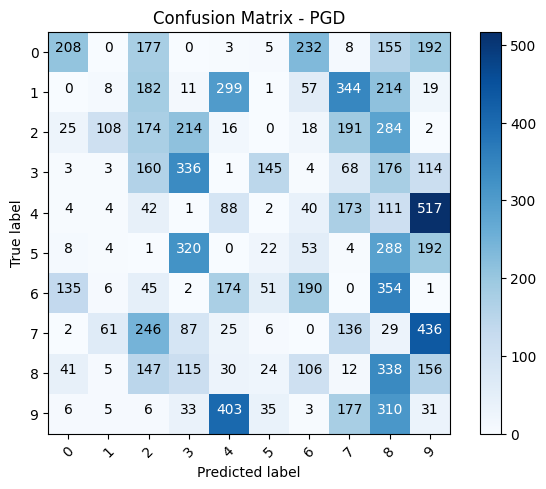

In [28]:
attack_plot_matrix(pgd_adv['PGD_adv'], loaded_mnist, y_test_labels, 'PGD', num_classes)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


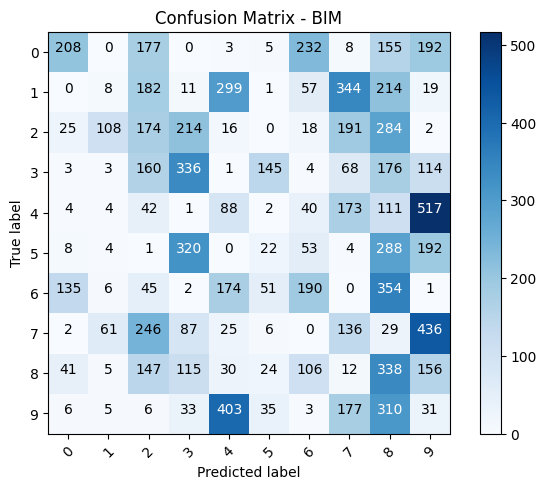

In [37]:
attack_plot_matrix(bim_adv['BIM_adv'], loaded_mnist, y_test_labels, 'BIM', num_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


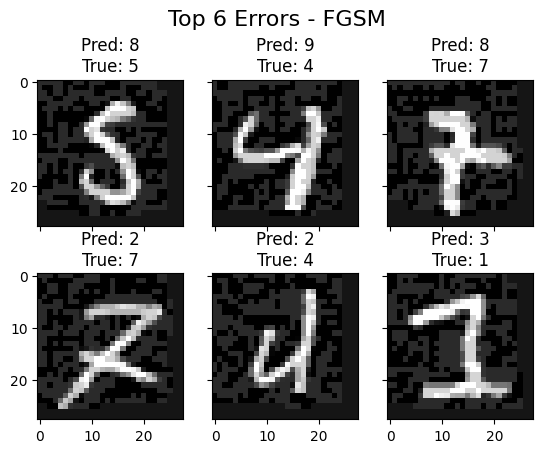

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


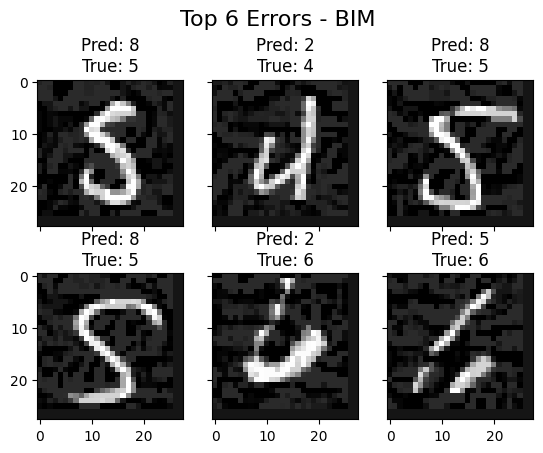

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


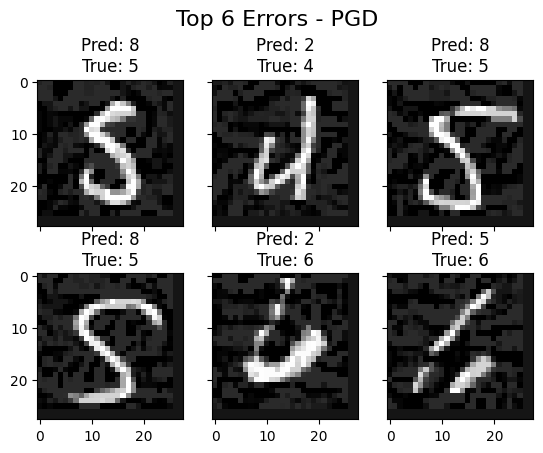

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


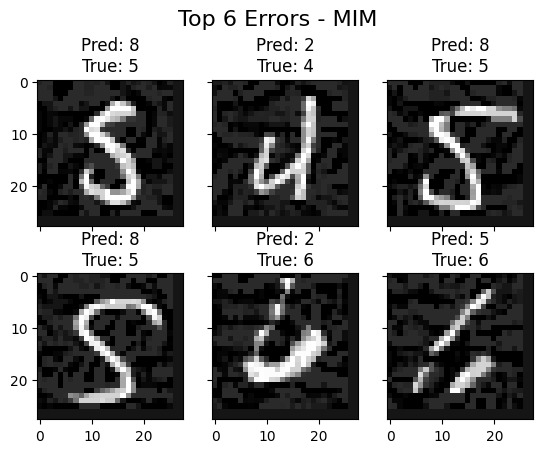

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


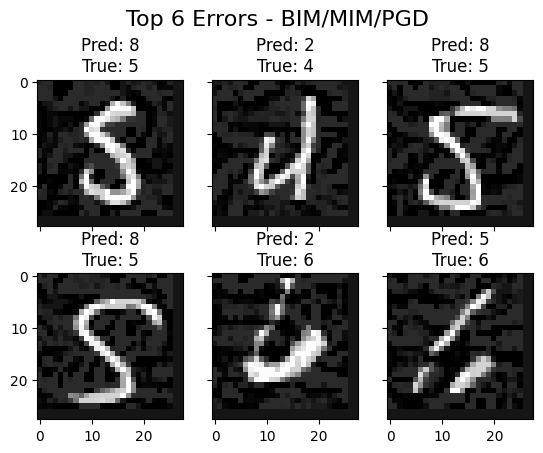

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display top errors
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            if n < len(errors_index):
                error = errors_index[n]
                ax[row, col].imshow((img_errors[error]).reshape((28, 28)), cmap='gray')
                ax[row, col].set_title("Pred: {}\nTrue: {}".format(pred_errors[error], obs_errors[error]))
                n += 1

# Function to find and display the top 6 errors for each attack
def top_errors(y_test, adv_images, attack_name):
    y_test_classes = np.argmax(y_test, axis=1)
    y_pred = loaded_mnist.predict(adv_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    errors = (y_pred_classes != y_test_classes)
    y_pred_classes_errors = y_pred_classes[errors]
    y_pred_errors = y_pred[errors]
    y_true_errors = y_test_classes[errors]
    x_val_errors = adv_images[errors]

    y_pred_errors_prob = np.max(y_pred_errors, axis=1)
    true_prob_errors = np.array([y_pred_errors[i, y_true_errors[i]] for i in range(len(y_true_errors))])
    delta_pred_true_errors = y_pred_errors_prob - true_prob_errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    most_important_errors = sorted_delta_errors[-6:]

    display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

    plt.suptitle(f'Top 6 Errors - {attack_name}', size=16)
    plt.subplots_adjust(top=0.85) 
    plt.show()

# Find and display the top errors for each attack
top_errors(y_test, fgsm_adv['FGSM_adv'], 'FGSM')
top_errors(y_test, bim_adv['BIM_adv'], 'BIM')
top_errors(y_test, pgd_adv['PGD_adv'], 'PGD')
top_errors(y_test, mim_adv['MIM_adv'], 'MIM')
top_errors(y_test, bim_adv['BIM_adv'], 'BIM/MIM/PGD')
